# Name Disambiguation

## enviroment setup

In [1]:
import numpy as np
import pandas as pd
import json
import re
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer


plt.rcParams['axes.unicode_minus'] = False


## global variables

In [8]:
TRAIN_AUTHOR = "./data/train/train_author.json"
TRAIN_PUB = "./data/train/train_pub.json"

SNA_VALID_AUTHOR_RAW = "./data/sna_data/sna_valid_author_raw.json"
SNA_VALID_EXAMPLE = "./data/sna_data/sna_valid_example_evaluation_scratch.json"
SNA_VALID_PUB = "./data/sna_data/sna_valid_pub.json"

## utils

In [9]:
def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

        
    

## explore the data

In [11]:
train_author_data = load_json(TRAIN_AUTHOR)
train_pub_data = load_json(TRAIN_PUB)
test_author_data = load_json(SNA_VALID_AUTHOR_RAW)
test_pub_data = load_json(SNA_VALID_PUB)
example_output = load_json(SNA_VALID_EXAMPLE)
 

### example

In [24]:
train_author_name_list = sorted(list(train_author_data.keys()))
print("train author names: ", train_author_name_list)


print("\n\n\ntest output")
TEST_NAME = "j_y_wang" #"guoliang_li"
for k, v in train_author_data.items():
    for idx, (id_, paper) in enumerate(v.items()):
        if k == TEST_NAME:
            print(f"index: {idx}, name: {k}, author id: {id_}, paper id list: {paper}")

    





train author names:  ['akio_kobayashi', 'akira_ono', 'alessandro_giuliani', 'alexander_belyaev', 'bai_yang', 'baoli_zhu', 'bin_gao', 'bin_hu', 'bin_yao', 'bin_zhang', 'bin_zhao', 'bing_chen', 'bing_zhang', 'bing_zhao', 'bo_jiang', 'bo_shen', 'bo_zhang', 'bo_zhou', 'c_c_lin', 'c_c_wang', 'c_yang', 'changhong_wang', 'changming_liu', 'changsheng_li', 'chao_chen', 'chao_deng', 'chao_yuan', 'chao_zhang', 'chen_liu', 'cheng_yang', 'cheng_zhu', 'chenguang_wang', 'chuan_he', 'chunxia_li', 'd_li', 'd_zhang', 'dan_wang', 'dan_wu', 'di_wang', 'di_wu', 'di_zhang', 'dong_xu', 'dongsheng_wang', 'f_liu', 'fang_wang', 'fei_liu', 'fei_qi', 'feng_gao', 'feng_li', 'feng_liu', 'feng_wu', 'feng_zhao', 'feng_zhu', 'furong_gao', 'gang_pan', 'gang_zhang', 'guang_yang', 'guanghua_li', 'guochun_zhao', 'guohua_chen', 'guoliang_li', 'guoqing_hu', 'hai_jin', 'hai_yang', 'haijiang_wang', 'haiying_wang', 'hao_huang', 'hao_yan', 'heqing_huang', 'hideaki_takahashi', 'hiroaki_okamoto', 'hiroshi_sakamoto', 'hong_cheng',

In [26]:

print(f"train pub exmaple, name: {TEST_NAME}")
print("same author:")
pprint(train_pub_data["UHYujqML"]["authors"])
print()
pprint(train_pub_data["b3ZiQ3LB"]["authors"])
print()
pprint(train_pub_data["nX5dPm1V"]["authors"])

print("\n\ndifferet author:")
pprint(train_pub_data["lNpXU2Oo"]["authors"])
pprint(train_pub_data["77H13FlR"]["authors"])
pprint(train_pub_data["NwjJw4ks"]["authors"])

train pub exmaple, name: j_y_wang
same author:
[{'name': 'X.B. Hu', 'org': ''},
 {'name': 'J.Y. Wang', 'org': ''},
 {'name': 'W.H. Cui', 'org': ''},
 {'name': 'Q.C. Guan', 'org': ''},
 {'name': 'R.B. Song', 'org': ''},
 {'name': 'J.Q. Wei', 'org': ''},
 {'name': 'Y.G. Liu', 'org': ''},
 {'name': 'J.H. Jiang', 'org': ''},
 {'name': 'Y.L. Tian', 'org': ''}]

[{'name': 'Q.T. Gu', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'J.Q. Wei', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'M.K. Lu', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'H.S. Zhuo', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'J.Y. Wang', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'C.S. Fang', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'G. Landwehr', 'org': 'Physikalisches Inst. Univ. Wurzburg'},
 {'name': 'H. Reß', 'org': 'Physikalisches Inst. Univ. Wurzburg'}]

[{'name': 'C.S. Fang', 'org': 'Stt. Key Lab. of Crystal Materials'},
 {'name': 'Q.T. Gu', 'o

## data statistics

In [54]:
author_name_set = set()
for k, v in train_author.items():
    for id_, papers in v.items():
        for paper_id in papers:
            for author_info in train_pub[paper_id]['authors']:
                author_name_set.add(author_info['name'])

print(len(author_name_set))
       

371850


### training data

author name count before disambiguation:  221
author name count after disambiguation: 22839
average count per author name  before disambiguation:  103.34
total paper count: 205498
average paper per author (before disambiguation): 930
average paper per author (after disambiguation): 9


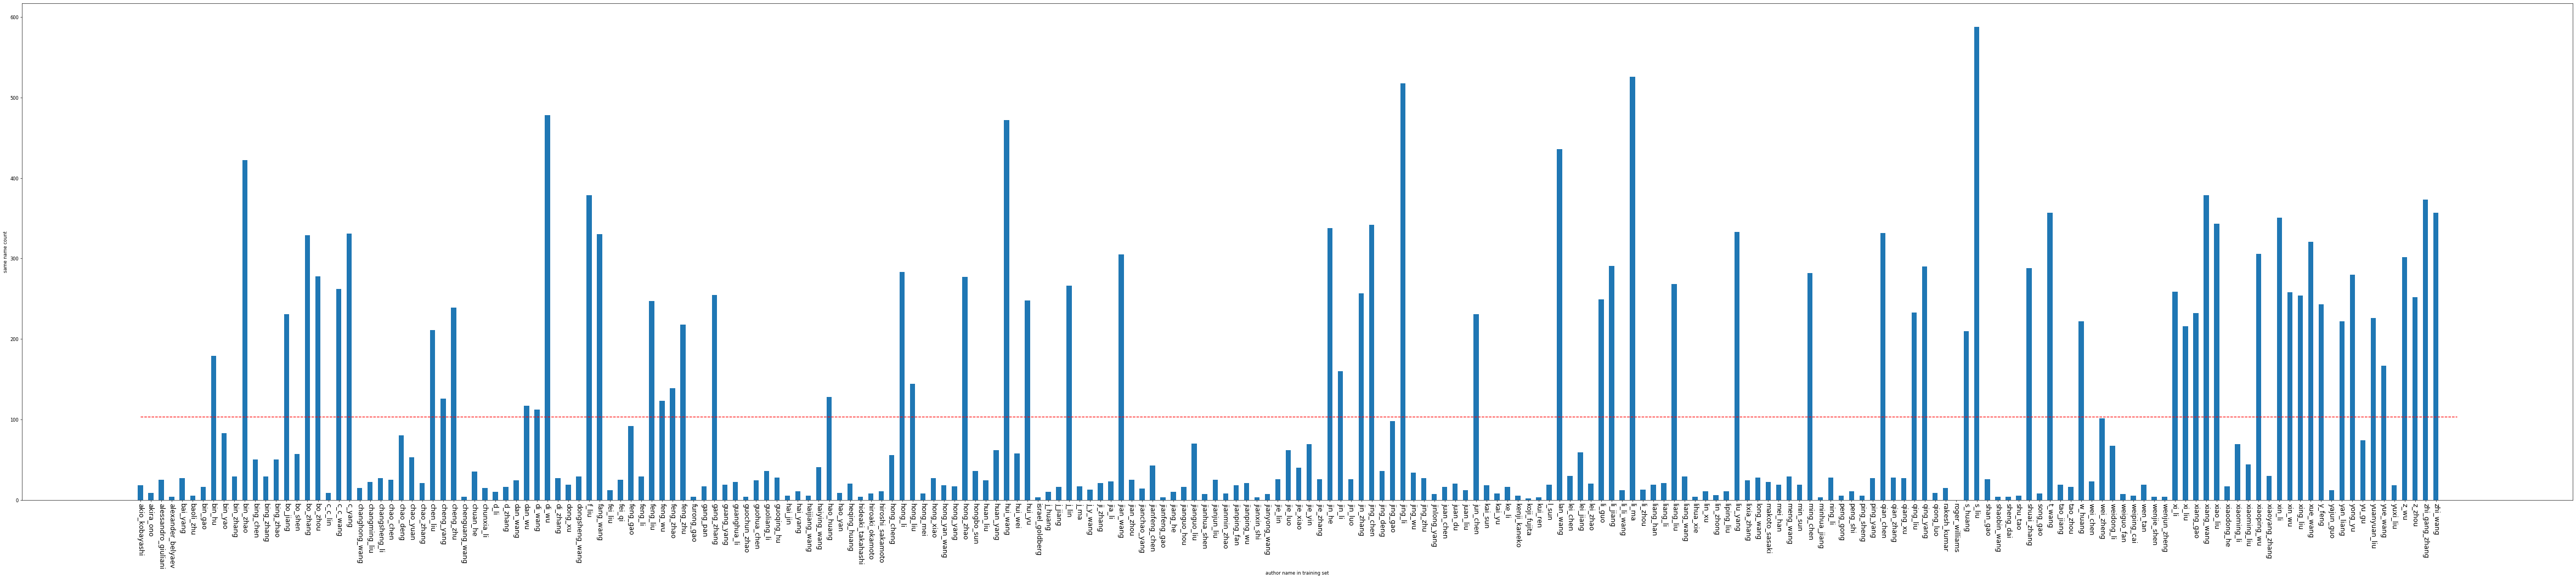

In [31]:
author_name_list = sorted([k for k in train_author_data.keys()])
author_same_name_count = dict((k, len(train_author_data[k].keys())) for k in train_author_data.keys())


author_count_before_disambiguation = len(author_name_list)
author_count_after_disambiguation = sum([author_same_name_count[k] for k in train_author_data])

print("author name count before disambiguation: ", author_count_before_disambiguation)
print("author name count after disambiguation:", author_count_after_disambiguation)

plt.figure(figsize=(100, 20), dpi=60)
x = range(len(author_name_list))

plt.bar(x, [author_same_name_count[k] for k in author_name_list], width=0.5)
plt.xticks(x, author_name_list)
plt.xticks(rotation=270) 
plt.xticks(fontsize = 15)
plt.xlabel("author name in training set")
plt.ylabel("same name count")

avg_count = np.mean([author_same_name_count[k] for k in author_name_list])
print(f"average count per author name  before disambiguation: {avg_count: .2f}")
plt.hlines(avg_count, 0, len(author_name_list) + 1, linestyles = "--", color = "red", label = f"average: {avg_count}")


total_paper_count = 0
for name in train_author_data.keys():
    for v in train_author_data[name].values():
        total_paper_count += len(v)

print(f"total paper count: {total_paper_count}")
print(f"average paper per author (before disambiguation): {total_paper_count/author_count_before_disambiguation :.0f}")
print(f"average paper per author (after disambiguation): {total_paper_count/author_count_after_disambiguation :.0f}")
        




### validation data

In [35]:
for author in test_author_data.keys():
    pass
    #print(author)
    
#test example
print("\n\n\ntest author data")
print(test_author_data["heng_li"])

print("\n\n\ntest pub data")
pprint(test_pub_data["zszavvJh"])

print("\n\nsubmisssion example:")
print(example_output["heng_li"])





test author data
['zszavvJh', 'a2Tl88Xu', 'X3Y0AYBw', '0kUbjIMW', '4bKZMNxE', 'vbQeLjWI', 'ZfSbG5ME', 'ierOTBz1', '6cXZA7zu', 'cXBXYa63', '141Kx9Ce', 'Gfl2GwXG', '98xkec8D', '2MIIwgBH', 'yVCAyLJo', 'NaPOuXXF', 'YoRqTILd', 'V8UOM2uU', 'wtiZkPVr', 'qggv8F0K', 'uDsLiLZd', 'FIVcmK6w', 'M2YJ0Dfa', 'QqQNHt3b', 'Cpi5vz3j', '7wJu2eAh', 'dUlZsS5z', 'cZnZW9uz', 'bxkStxS7', 'TH4B6A7Y', 'xn3xJkGU', 'xsbQHWyq', 'B5HNDTzE', 'MsT3Sml8', 'PO61SLCN', 'SCvnHfAx', 'pFmfB3Hm', 'qFyL0b7h', 'MdbnxBrH', 'WDe4ltiG', '4eHVOVB7', '8OiM0qmf', 'Q62Py6ew', 'Jmcve9yI', '475s6I47', 'OnwXGiRR', 'CUbTTLzf', '4DaB8tVN', 'oim5ZjhO', 'OyhZ1MiB', 'KZzOrPpy', 's0UYiQ6B', '0GzWz3O4', 'kWe0u2Ih', 'AyFd9xZZ', 'N7J7fEeF', 'C1WBo3Cs', 'Lg5JGKID', 'W6leQ8fX', 'qyh46ML8', 'ojqAGDyS', 'aA4FOt2Y', 'x3h6uA0c', 'tWxrqzEO', 'goiijZU0', 'wyionLg7', 'RQzk9gxv', 'spGZlbgg', 'X7DSjudv', 'JOAqAYeR', 'ynRw5omI', 'cQAaLgVP', '2J2G5bPa', '8X7NKYO8', 'eFRsCR81', 'KSWkp6m2', 'wme6V0aL', '5HLZuQ0p', 'dP2aIUjO', 'Vif917Gy', 'c8ngM97e', 'OFZvRr

In [39]:
valid_data = dict()
for author in test_author_data.keys():
    if "_" in author:
        print(author)
    
    valid_data[author] = [test_pub_data[paper_id] for paper_id in test_author_data[author]]
  


author_name_list = valid_data.keys()
papers_per_author = [len(valid_data[author]) for author in author_name_list]

print(f"valid author name count: {len(author_name_list)}")
print(f"average paper per author: {np.mean(papers_per_author): .2f}")
    
#examples
test_name = "shiyi_chen"
print(f"test name: {test_name}")
for v in valid_data[test_name]:
    print(f"\npaper id: {v['id']}")
    for n in v["authors"]:
          print(n["name"])
    

heng_li
fang_chen
lin_zhou
akio_yamamoto
y_luo
chun_li
shiyi_chen
zhigang_chen
chun_wang
j_yu
y_guo
g_li
jing_huang
atsushi_takeda
fei_gao
rajendra_prasad
qi_li
bin_ren
yong_cao
jing_zhou
hong_jiang
liang_zhou
ming_xu
jie_sun
hao_zhang
jue_wang
y_shi
jian_huang
ping_zhang
feng_zhou
dong_zhang
h_yu
jian_wu
li_huang
shiyong_liu
ke_xu
min_yang
lei_wu
jie_zhou
zhang_lei
h_y_wang
qing_li
d_wang
hongsheng_chen
kun_li
hong_guo
gang_chen
yuanyuan_zhang
lin_ma
yao_zhang
valid author name count: 50
average paper per author:  917.96
test name: shiyi_chen

paper id: lsXG1s34
Hua Yinghui
Chen Shiyi
Zhai Weitao
Chen Jiwu
Li Yunxia
Wu Wei

paper id: Me1wpE9Y
Shang Xiliang
Chen Shiyi
Ren Huimin
Li Yunxia
Huang He
Zhang Jian

paper id: XnaM91Hr
Li Hong
Chen Chen
Zhang Shurong
Jiang Jia
Tao Hongyue
Xu Jialing
Sun Jianguo
Zhong Wei
Chen Shiyi

paper id: jZ3FQhj7
Chen ShiYi
Chen YingChun
Xia ZhenHua
Qu Kun
Shi YiPeng
Xiao ZuoLi
Liu QiuHong
Cai QingDong
Liu Feng
Lee Cunbiao
Zhang RiKui
Cai JinSheng

paper 

## data prepprocessing

In [41]:
def preprocess_name(name):   
    name = name.lower().replace(' ', '_')
    name = name.replace('.', '_')
    name = name.replace('-', '')
    name = re.sub(r"_{2,}", "_", name) 
    return name


def preproces_sorg(org):
    if org != "":
        org = org.replace('Sch.', 'School')
        org = org.replace('Dept.', 'Department')
        org = org.replace('Coll.', 'College')
        org = org.replace('Inst.', 'Institute')
        org = org.replace('Univ.', 'University')
        org = org.replace('Lab ', 'Laboratory ')
        org = org.replace('Lab.', 'Laboratory')
        org = org.replace('Natl.', 'National')
        org = org.replace('Comp.', 'Computer')
        org = org.replace('Sci.', 'Science')
        org = org.replace('Tech.', 'Technology')
        org = org.replace('Technol.', 'Technology')
        org = org.replace('Elec.', 'Electronic')
        org = org.replace('Engr.', 'Engineering')
        org = org.replace('Aca.', 'Academy')
        org = org.replace('Syst.', 'Systems')
        org = org.replace('Eng.', 'Engineering')
        org = org.replace('Res.', 'Research')
        org = org.replace('Appl.', 'Applied')
        org = org.replace('Chem.', 'Chemistry')
        org = org.replace('Prep.', 'Petrochemical')
        org = org.replace('Phys.', 'Physics')
        org = org.replace('Phys.', 'Physics')
        org = org.replace('Mech.', 'Mechanics')
        org = org.replace('Mat.', 'Material')
        org = org.replace('Cent.', 'Center')
        org = org.replace('Ctr.', 'Center')
        org = org.replace('Behav.', 'Behavior')
        org = org.replace('Atom.', 'Atomic')
        org = org.split(';')[0]
        org = org.lower()
    return org

#remove seprators
def etl(content):
    content = re.sub("[\s+\.\!\/,;$%^*(+\"\')]+|[+——()?【】“”！，。？、~@#￥%……&*（）]+", " ", content)
    content = re.sub(r" {2,}", " ", content)
    return content

def get_org(co_authors, author_name):
    for au in co_authors:
        name = precessname(au['name'])
        name = name.split('_')
        if ('_'.join(name) == author_name or '_'.join(name[::-1]) == author_name) and 'org' in au:
            return au['org']
    return ''
    

## disambiguate 

In [43]:
def disambiguate():
    result_dict = {}
    for author in test_author_data.keys():
        print(author)
        
        feature_string_list = []
        papers = test_author_data[author]
        if len(papers) == 0:
            result_dict[author] = []
            continue
        
        print("paper count: ", len(papers))
        paper_dict = {}
        for paper in papers:
           
            feature_list = []
            
            for k in test_pub_data[paper]["authors"]:
                if "name" in k:
                    #name_list.append(preprocessname(k["name"]))
                    feature_list.append(preprocess_name(k["name"]))
                if "org" in k:
                    #org_list.append(preprocessorg(k["org"]))
                    feature_list.append(preproces_sorg(k["org"]))                    
            
            if "abstract" in test_pub_data[paper]:
                feature_list.append(test_pub_data[paper]["abstract"])
            
            
            feature_string = etl(" ".join(feature_list))
            feature_string_list.append(feature_string)
        
        print("feature string list length:", len(feature_string_list))
        tfidf = TfidfVectorizer().fit_transform(feature_string_list)
        
        clf = DBSCAN(metric="cosine")
        s = clf.fit_predict(tfidf)
        print("labels")
        #print(clf.labels_)
        
        for label, paper in zip(clf.labels_, papers):
            if str(label) not in paper_dict:
                paper_dict[str(label)] = [test_pub_data[paper]["id"]]
            else:
                paper_dict[str(label)].append(test_pub_data[paper]["id"])
            
        #pprint(paper_dict)
        result_dict[author] = list(paper_dict.values())
        json.dump(result_dict, open("./result.json", "w", encoding='utf-8'), indent=4)
                
               
                    
                
        
        

disambiguate()

heng_li
paper count:  768
feature string list length: 768
labels
fang_chen
paper count:  314
feature string list length: 314
labels
lin_zhou
paper count:  980
feature string list length: 980
labels
akio_yamamoto
paper count:  272
feature string list length: 272
labels
y_luo
paper count:  162
feature string list length: 162
labels
chun_li
paper count:  318
feature string list length: 318
labels
shiyi_chen
paper count:  229
feature string list length: 229
labels
zhigang_chen
paper count:  1356
feature string list length: 1356
labels
chun_wang
paper count:  221
feature string list length: 221
labels
j_yu
y_guo
paper count:  708
feature string list length: 708
labels
g_li
paper count:  362
feature string list length: 362
labels
jing_huang
paper count:  1121
feature string list length: 1121
labels
atsushi_takeda
paper count:  78
feature string list length: 78
labels
fei_gao
paper count:  1346
feature string list length: 1346
labels
rajendra_prasad
paper count:  165
feature string list lengt